# I - Préliminaires - Fonctions utiles

In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "torch"

In [7]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Vérité Terrain')
    plt.xlabel('Prédiction')

# II - Entraînement d'un CNN pour la classification sur CIFAR10

### II.1. Chargement et Dimensionnement de la base CIFAR10

In [2]:
from keras import backend as K
print(K.backend())

torch


In [3]:
from keras.datasets import cifar10

In [4]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
print("Dimension de la base d'apprentissage CIFAR10 :",x_train_full.shape)
print("Dimension des vecteurs d'étiquette de classe :",y_train_full.shape)
print("Dimension de la base de test CIFAR10 :",x_test_full.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 81s 0us/step
Dimension de la base d'apprentissage CIFAR10 : (50000, 32, 32, 3)
Dimension des vecteurs d'étiquette de classe : (50000, 1)
Dimension de la base de test CIFAR10 : (10000, 32, 32, 3)


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Réduction de la taille du dataset (pour accélérer l'apprentissage), et standardisation des données

In [ ]:
n_training_samples = 5000
n_other_samples = 2000

def standardize(img_data):
    img_data_mean = np.mean(img_data, axis=(1,2), keepdims=True)
    img_data_std = np.std(img_data, axis=(1,2), keepdims=True)
    img_data = (img_data - img_data_mean) / img_data_std
    return img_data

train_ids = np.random.choice(len(x_train_full), size=n_training_samples, replace=False)
other_ids = np.random.choice(len(x_test_full), size=n_other_samples, replace=False)

n_valid = n_other_samples // 2
val_ids = other_ids[:n_valid]
test_ids = other_ids[n_valid:]

x_train_initial, y_train = x_train_full[train_ids], y_train_full[train_ids]
x_val_initial, y_val = x_test_full[val_ids], y_test_full[val_ids]
x_test_initial, y_test = x_test_full[test_ids], y_test_full[test_ids]

x_train = standardize(x_train_initial)
x_val = standardize(x_val_initial)
x_test = standardize(x_test_initial)

print("Dimension de notre base d'apprentissage :",x_train.shape)
print("Dimension des vecteurs d'étiquette de classe :",y_train.shape)
print("Dimension de notre base de validation :",x_val.shape)
print("Dimension de notre base de test :",x_test.shape)


Dimension de notre base d'apprentissage : (5000, 32, 32, 3)
Dimension des vecteurs d'étiquette de classe : (5000, 1)
Dimension de notre base de validation : (1000, 32, 32, 3)
Dimension de notre base de test : (1000, 32, 32, 3)


On affiche quelques images d'entraînement avec leur étiquette...

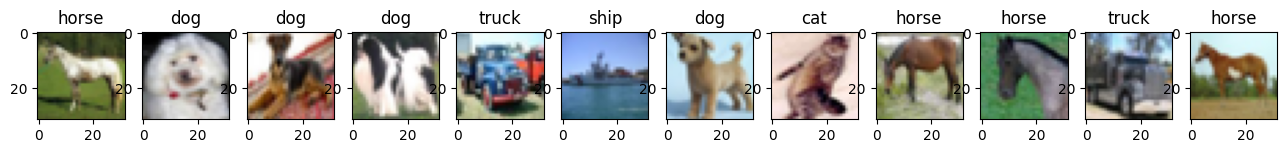

In [9]:
n_display = 12
random_ids = np.random.choice(len(x_train), n_display, replace=False)
f, axarr = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    axarr[k].imshow(x_train_initial[random_ids[k]])
    axarr[k].title.set_text(classes[y_train[random_ids[k]][0]])

In [10]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print("Dimension des matrices d'étiquette de classe (train) :",y_train.shape)
print("Dimension des matrices d'étiquette de classe (val) :",y_val.shape)
print("Dimension des matrices d'étiquette de classe (test) :",y_test.shape)

Dimension des matrices d'étiquette de classe (train) : (5000, 10)
Dimension des matrices d'étiquette de classe (val) : (1000, 10)
Dimension des matrices d'étiquette de classe (test) : (1000, 10)


### II.2. Definition de l'architecture du CNN

Un simple réseau convolutionnel... 

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(filters=8, 
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (32, 32, 3),
                kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))

c:\Users\rianradeck\MI204\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


On enregistre les poids initiaux pour plus tard...

In [12]:
weights_init = model.get_weights()

### II.3. Definition de la fonction de coût et choix de l'algorithme d'optimisation

In [32]:
from keras.optimizers import Adam, SGD

opt = SGD(learning_rate=0.01,momentum=0.0)
# opt = Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])

On affiche un résumé de la structure du modèle...

In [33]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,010 (515.66 KB)

 Trainable params: 132,010 (515.66 KB)

 Non-trainable params: 0 (0.00 B)

None


### II.4. Entraînement du CNN

*Definition du callback. A passer en première lecture.*

In [34]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq=2)

callbacks = [time_callback, checkpoint]

In [ ]:
import time
for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, verbose=1, validation_data=(x_val, y_val),
                        callbacks=[])
    steps = len(x_train) // batch_size
    
    epoch_time = time.time() - start_time
    print("Batch size:", batch_size, "- Epoch time:", epoch_time, "s")
    print("Average step time:", epoch_time/steps * 1000, "ms")
    

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - acc: 0.9769 - loss: 0.0816 - val_acc: 0.3540 - val_loss: 3.5477
Batch size: 1  - Epoch time: 57.03107500076294 s
Average step time: 11.406215000152587 ms
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - acc: 0.8813 - loss: 0.3473 - val_acc: 0.3940 - val_loss: 4.2403
Batch size: 2  - Epoch time: 16.383333444595337 s
Average step time: 6.553333377838134 ms
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - acc: 0.9775 - loss: 0.0662 - val_acc: 0.4130 - val_loss: 4.2142
Batch size: 4  - Epoch time: 8.321871042251587 s
Average step time: 6.65749683380127 ms
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.9965 - loss: 0.0203 - val_acc: 0.4210 - val_loss: 4.2818
Batch size: 8  - Epoch time: 5.622475862503052 s
Average step time: 8.995961380004882 ms
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.9972 - loss: 0.0153 - val_acc: 0.4250 - val_loss: 4.3316
Batch size: 16  - Epoch time: 2.9016385078430176 s
Average step time: 9.300123422573774 ms
157/157 

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val),
                        callbacks=callbacks)

Statistiques sur le temps d'entraînement d'une epoch

In [19]:
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))

Mean: 1.6827680230140687
Std: 0.22978870400831328


Tracé des courbes d'évolution des fonctions de coût

In [20]:
history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

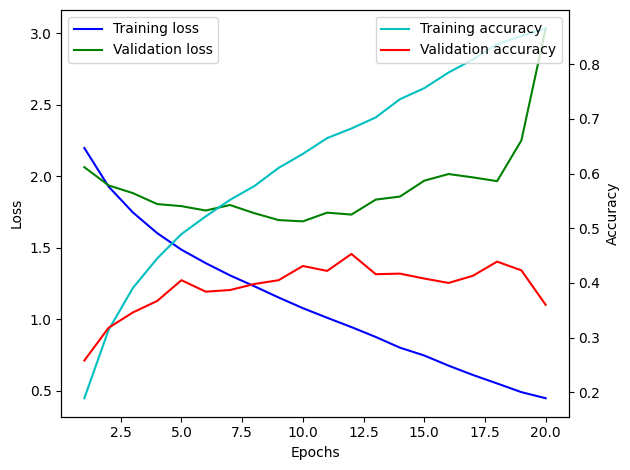

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

### II.5. Entraînement d'un CNN avec points d'arrêt et reprises (à passer en première lecture)

Pour des entraînements plus conséquents, il est primordial d'enregistrer les modèles intermédiaires afin de ne pas tout perdre si l'apprentissage venait à s'interrompre de façon impromptue. On peut enregistrer le modèle dans un fichier .hdf

Si vous regardez plus attentivement, lors de l'entrainement précédent nous avons crée un object **ModelCheckpoint**. Il permet d'enregistrer le meilleur modèle (au sens d'une metrique à préciser) dans un fichier nommé *my_model.h5*. Verifiez que ce fichier se trouve bien votre espace de travail.

L'argument ***period*** de l'objet ModelCheckpoint vous permet de definir la fréquence des enregistrements.

In [22]:
from keras.models import load_model

Une fois le modele obtenu, on peut l'enregister et le recharger comme ceci: load_model(filepath)

In [23]:
from keras.models import load_model

import pathlib
file = pathlib.Path(filepath)
if file.exists():
    model = load_model(filepath)
else:
    model.set_weights(weights_init)
    callbacks = [time_callback,checkpoint]
history_2 = model.fit(x_train, y_train, batch_size=8, epochs=10, verbose=1, validation_data=(x_val, y_val),
                      callbacks = callbacks)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.2130 - loss: 2.1609 - val_acc: 0.3530 - val_loss: 1.7911
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.4248 - loss: 1.6202 - val_acc: 0.4050 - val_loss: 1.6985
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.5167 - loss: 1.3807 - val_acc: 0.4380 - val_loss: 1.5837
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.5794 - loss: 1.2230 - val_acc: 0.4440 - val_loss: 1.6024
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.6323 - loss: 1.0608 - val_acc: 0.4290 - val_loss: 1.6703
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.6984 - loss: 0.8968 - val_acc: 0.4640 - val_loss: 1.6908
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.7742 - loss: 0.6960 - val_acc: 0.4490 - val_loss: 1.8480
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.8171 - loss: 0.5787 - val_acc: 0.4480 - val_loss: 1.8781
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - ac

# III - Test et Évaluation du modèle en prédiction

### III.1. Test du modèle sur les données de test

Testons la prédiction de notre modèle sur quelques images de test au hasard...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


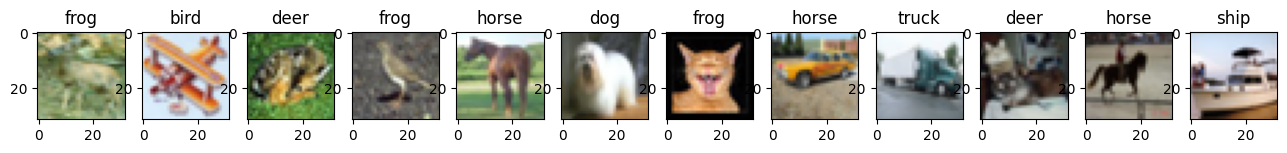

In [24]:
random_ids = np.random.choice(len(x_test), n_display, replace=False)
pred = np.argmax(model.predict(x_test[random_ids]), axis=1)
f, axarr = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    axarr[k].imshow(x_test_initial[random_ids[k]])
    axarr[k].title.set_text(classes[pred[k]])

Vos premiers résultats semblent-ils corrects ?

Hum ! Affichons à présent la précision sur l'ensemble de votre base :

In [25]:
print("Précision du réseau sur les {} images d'entraînement : {:.2f} %".format(n_training_samples, 100 * history_dict['acc'][-1]))
print("Précision du réseau sur les {} images de validation : {:.2f} %".format(n_valid, 100 * history_dict['val_acc'][-1]))

Précision du réseau sur les 5000 images d'entraînement : 86.56 %
Précision du réseau sur les 1000 images de validation : 36.00 %


In [26]:
def accuracy_per_class(model):
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)
    
    pred = np.argmax(model.predict(x_test), axis=1)
    for i in range(len(y_test)):
        confusion_matrix[np.argmax(y_test[i]), pred[i]] += 1
    
    print("{:<10} {:^10}".format("Classe", "Précision (%)"))
    total_correct = 0
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        total_correct += class_correct
        percentage_correct = 100.0 * float(class_correct) / class_total
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    test_acc = 100.0 * float(total_correct) / len(y_test)
    print("Précision du réseau sur les {} images de test : {:.2f} %".format(len(y_test),test_acc))
    return confusion_matrix

confusion_matrix = accuracy_per_class(model)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classe     Précision (%)
plane        15.38   
car          62.07   
bird         55.32   
cat          14.58   
deer         24.75   
dog          33.91   
frog         52.43   
horse        45.54   
ship         81.63   
truck        33.66   
Précision du réseau sur les 1000 images de test : 41.40 %


### III.2. Matrices de Confusion

Les matrices de confusion nous renseignent plus précisément sur la nature des erreurs commises par notre modèle.

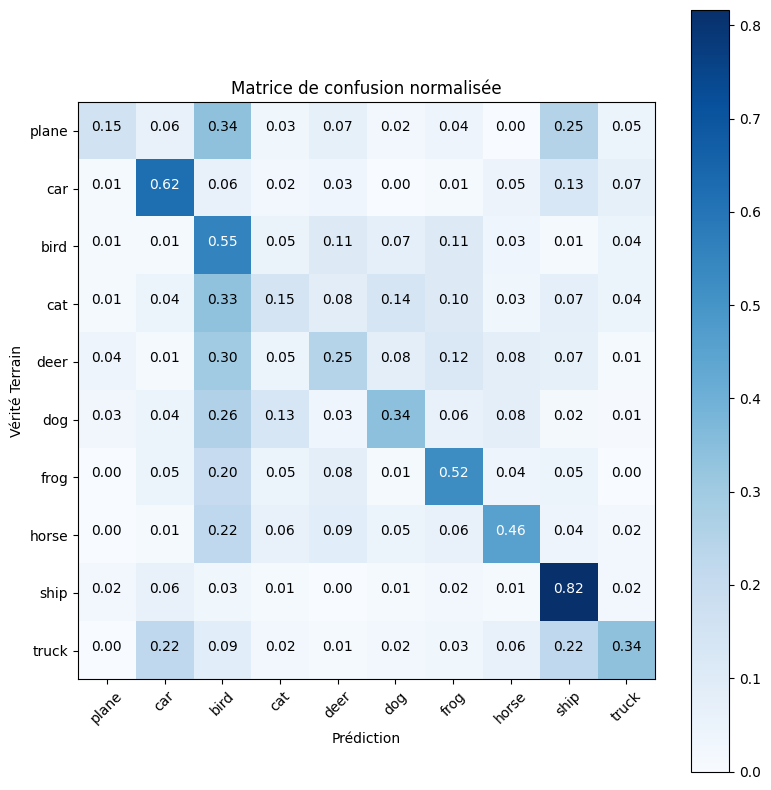

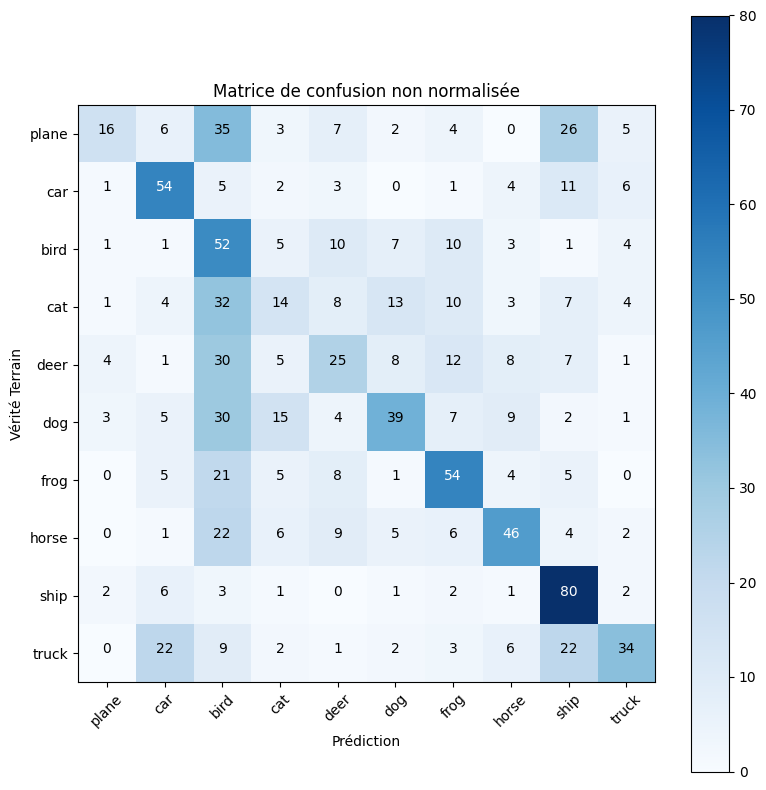

In [27]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Matrice de confusion normalisée')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Matrice de confusion non normalisée')

# IV - Visualisation des zones d'activation

In [28]:
from keras.models import Model

reduced_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
reduced_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224 (896.00 B)

 Trainable params: 224 (896.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
feature_maps = reduced_model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\rianradeck\MI204\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=torch.Size([32, 32, 32, 3]))
  warnings.warn(msg)
c:\Users\rianradeck\MI204\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=torch.Size([8, 32, 32, 3]))
  warnings.warn(msg)


In [30]:
def get_mask(k):
    feature_maps_positive = np.maximum(feature_maps[k], 0)
    mask = np.sum(feature_maps_positive,axis=2)
    mask = mask / np.max(mask)
    return mask

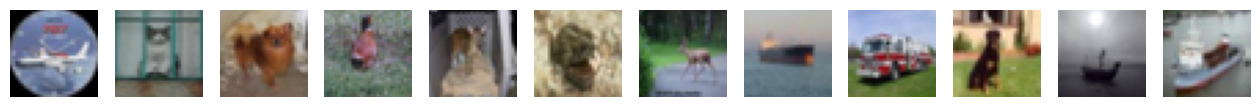

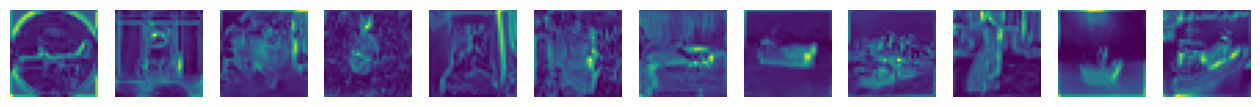

In [31]:
random_ids = np.random.choice(len(x_test), n_display, replace=False)
f, rd_img = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    img = x_test_initial[random_ids[k]]
    rd_img[k].imshow(img)
    rd_img[k].axis('off')
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k])
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')